In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import v2

from main_event import prepare_event_data, prepare_json_event_data
from models.lstm import LSTM
from models.gru import GRU
from models.main import get_model, train_model
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    calculate_velocity_acceleration_direction,
    get_frame_data,
    plot_accuracy_history,
    plot_confusion_matrix,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted,
    expand_dataset
)

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players for the First Period

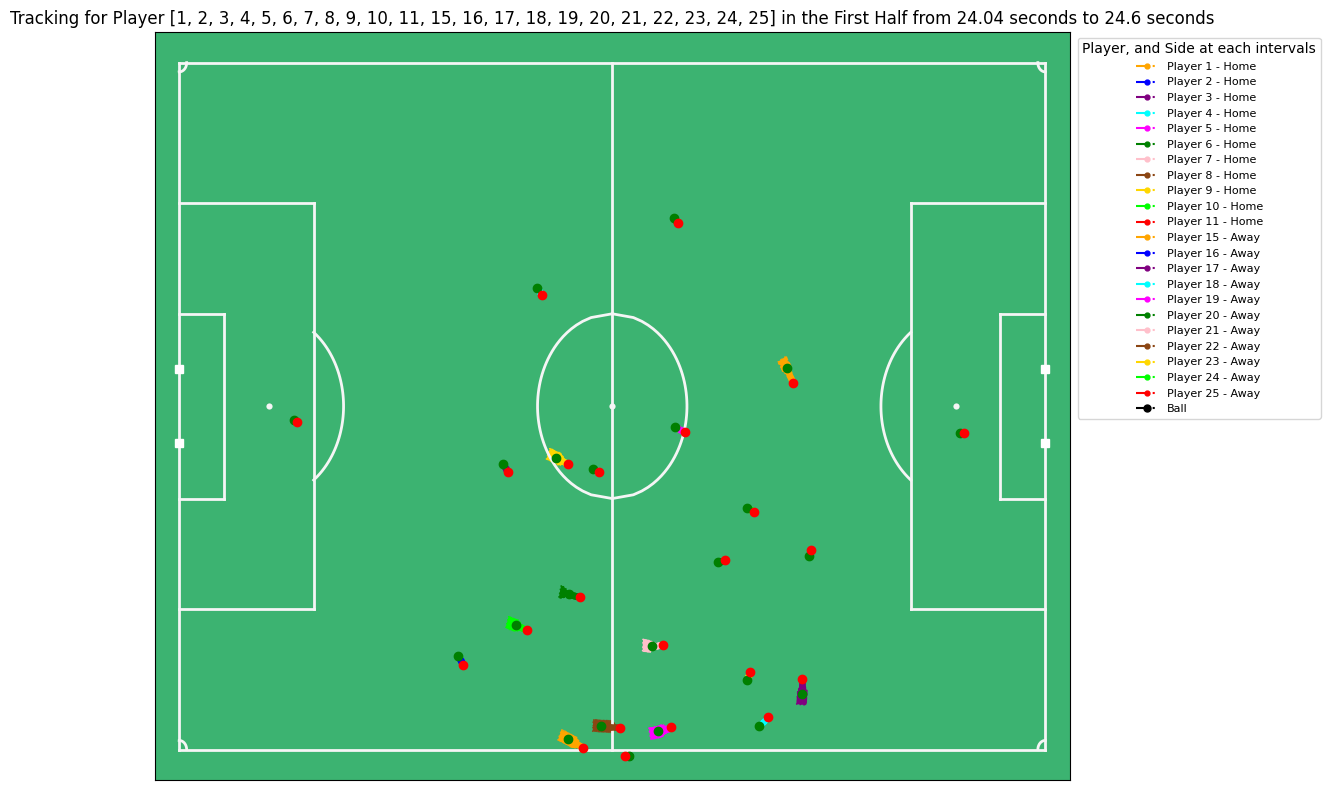

In [8]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_2_data.iloc[600:615], players=players, sides=sides, plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

# Adding extra features to dataset

In [14]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [15]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,-1.000000,NaN,0.0,-1.000000,NaN,0.0,-0.846472,NaN,0.422814
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.0,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.902134,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.929961,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.5547,-0.997870,0.000091,-0.697865,-0.995711,3.062708e-04,-0.985212,-1.000000,-0.000254,0.0
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.993884,-0.997756,0.000057,-0.662198,-0.994511,5.998815e-04,-0.981847,-1.000000,-0.000254,0.0
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.56921,-0.997837,-0.000040,-0.650791,-0.997771,-1.629783e-03,-0.796691,-1.000000,-0.000254,0.0
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.68826,-0.997653,0.000092,-0.183282,-0.998101,-1.648699e-04,-0.354654,-1.000000,-0.000254,0.0


In [16]:
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,-0.987500,-0.998055,NaN,-0.832050,-0.996797,NaN,0.164399,-1.0,NaN,0.0
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,-0.999947,-0.995360,-0.004145,0.581238,-0.997645,-0.010160,0.447214,-1.0,0.006941,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,-0.995175,-0.993881,-0.004782,0.652242,-0.989855,-0.005611,-0.975942,-1.0,0.006941,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,-0.988936,-0.994643,-0.005958,0.422885,-0.995887,-0.012889,-0.973080,-1.0,0.006941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,-0.937994,-0.997054,-0.005001,-0.915315,-0.992880,-0.009870,0.488153,-1.0,0.006941,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,-0.749329,-0.994111,-0.004015,0.989203,-0.988232,-0.007265,0.698100,-1.0,0.006941,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,-0.566529,-0.990685,-0.003761,0.880099,-0.985007,-0.008015,0.407442,-1.0,0.006941,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.595454,-0.984222,-0.002168,0.902481,-0.985342,-0.009890,0.129339,-1.0,0.006941,0.0


In [17]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different

In [18]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0,-1.0,NaN,0.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.8,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.791285,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.977582,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.83205,-1.0,0.001487,0.0,-1.0,0.001491,0.0,-1.0,-0.002262,0.0


In [19]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [20]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

# Classification

In [21]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [22]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [23]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [24]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [25]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [26]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [27]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [28]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_22_direction,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.0,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.902134,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.929961,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,-0.071247,-0.995303,0.000620,-0.774328,-0.989728,1.571950e-03,0.775019,-0.944349,-0.000256,-0.995102
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,-0.742393,-0.995575,-0.000136,-0.698213,-0.991338,-8.049408e-04,0.551433,-0.944349,-0.000254,-0.995102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.447214,-0.996472,-0.000259,0.809215,-0.987762,-7.220017e-05,0.195154,-0.983072,-0.000265,-0.777978
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.404595,-0.996613,-0.000070,0.808236,-0.987954,-9.605656e-05,0.193182,-0.983051,-0.000244,-0.777016
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.438424,-0.996676,-0.000031,0.8,-0.988086,-6.597336e-05,0.190182,-0.983072,-0.000265,-0.777978
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.471157,-0.996385,0.000145,0.854616,-0.988108,-1.134267e-05,0.180245,-0.983025,-0.000231,-0.777793



### Adding which team has the ball using distance metrics

In [29]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[X_1.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[X_1.index, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[X_1.index, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[X_2.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[X_2.index, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[X_2.index, "P_11_velocity":]
game_3_players, game_3_ball, game_3_vel_acc = vel_acc_game_3_data.loc[X_3.index, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_3_data.loc[X_3.index, "Ball-x":"Ball-y"], vel_acc_game_3_data.loc[X_3.index, "P_11_velocity":]

In [30]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data.loc[X_1.index],
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
6,0.24,0.563151,0.349641,0.242261,0.249360,0.295297,0.365688,0.166072,0.177541,0.208422,...,0.179660,0.142050,0.393339,0.269474,0.102840,0.287690,0.043790,0.558136,0.361370,0.213209
7,0.28,0.567758,0.362466,0.250968,0.248928,0.287334,0.380255,0.176221,0.173689,0.196685,...,0.162456,0.149593,0.408004,0.282869,0.105487,0.302437,0.059987,0.574458,0.347387,0.207090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,5744.56,0.804350,0.185293,0.427381,0.428353,0.056973,0.095513,0.184103,0.519533,0.082591,...,0.114894,0.030264,0.086602,0.363107,0.154489,0.155523,0.009879,0.381254,0.393613,0.225027
143615,5744.60,0.806604,0.186092,0.428208,0.430656,0.060635,0.092409,0.186681,0.518725,0.080450,...,0.116965,0.026288,0.089510,0.362792,0.151052,0.156188,0.015445,0.378841,0.394586,0.225026
143616,5744.64,0.808892,0.187006,0.429086,0.432985,0.064416,0.090174,0.189370,0.517919,0.078450,...,0.119181,0.023143,0.092503,0.362527,0.147764,0.156886,0.021004,0.376427,0.395626,0.225129
143617,5744.68,0.811206,0.188044,0.430041,0.435382,0.068212,0.090508,0.192103,0.517189,0.076664,...,0.121536,0.021172,0.095605,0.362424,0.144597,0.157611,0.026631,0.374041,0.396738,0.225333


In [31]:
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data.loc[X_2.index],
    player_data=game_2_players,
    ball_data=game_2_ball
)
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
146,5.84,0.496703,0.342948,0.277024,0.236026,0.373352,0.313091,0.180737,0.153203,0.257618,...,0.300610,0.114074,0.135304,0.244139,0.380443,0.000552,0.156475,0.510173,0.154591,0.171414
147,5.88,0.495560,0.339008,0.274342,0.236814,0.377921,0.307608,0.177571,0.154230,0.262085,...,0.306740,0.118177,0.130822,0.238153,0.385671,0.006124,0.150416,0.503450,0.156447,0.167461
148,5.92,0.494714,0.335354,0.272058,0.237919,0.382450,0.302357,0.174755,0.155649,0.266488,...,0.312700,0.122323,0.126521,0.232338,0.390834,0.012529,0.144592,0.496938,0.158735,0.163931
149,5.96,0.493924,0.331728,0.269874,0.239181,0.387007,0.297109,0.172067,0.157306,0.270939,...,0.318660,0.126717,0.122443,0.226515,0.396016,0.019004,0.138811,0.490421,0.161263,0.160582
150,6.00,0.493213,0.328212,0.267811,0.240609,0.391537,0.291942,0.169492,0.159178,0.275354,...,0.324600,0.131340,0.118528,0.220701,0.401187,0.025408,0.133247,0.483911,0.164015,0.157506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [32]:
game_3_result = calculate_player_ball_distances(
    game_data=game_3_data.loc[X_3.index],
    player_data=game_3_players,
    ball_data=game_3_ball
)
game_3_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
384,15.36,0.352504,0.331159,0.256519,0.284357,0.429872,0.378481,0.119092,0.000400,0.180356,...,0.346157,0.223549,0.211809,0.328314,0.132664,0.086096,0.074542,0.142414,0.148002,0.117704
385,15.40,0.351206,0.332361,0.255612,0.282324,0.428503,0.380764,0.117909,0.003158,0.178264,...,0.345420,0.223845,0.213747,0.330944,0.131090,0.085358,0.075985,0.144785,0.145465,0.118950
386,15.44,0.348255,0.334462,0.253864,0.277877,0.425091,0.384800,0.115926,0.008345,0.173728,...,0.343813,0.224480,0.217718,0.335997,0.128306,0.084851,0.079418,0.149504,0.141060,0.122100
387,15.48,0.345348,0.336726,0.252235,0.273450,0.421719,0.388662,0.114108,0.013467,0.169228,...,0.342284,0.225251,0.221681,0.341090,0.125653,0.084581,0.082921,0.154277,0.136661,0.125282
388,15.52,0.342459,0.339027,0.250612,0.269035,0.418362,0.392650,0.112378,0.018609,0.164744,...,0.340763,0.226084,0.225644,0.346147,0.123156,0.084541,0.086549,0.159133,0.132340,0.128482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,5741.16,0.757354,0.451340,0.512179,0.456022,0.484797,0.294182,0.351505,0.283820,0.373873,...,0.629015,0.075225,0.365217,0.600645,0.393664,0.412268,0.252676,0.422322,0.467580,0.351770
143530,5741.20,0.759984,0.452956,0.516748,0.459150,0.484995,0.298928,0.355475,0.285778,0.371533,...,0.626339,0.076360,0.370834,0.606412,0.397196,0.412906,0.256383,0.427348,0.470827,0.347940
143531,5741.24,0.762663,0.454658,0.521307,0.462330,0.485265,0.303622,0.359477,0.287854,0.369232,...,0.623813,0.077862,0.376445,0.612175,0.400782,0.413675,0.260164,0.432423,0.474142,0.344226
143532,5741.28,0.765381,0.456408,0.525908,0.465563,0.485640,0.308268,0.363557,0.290019,0.367110,...,0.621293,0.079760,0.382045,0.617958,0.404413,0.414503,0.264029,0.437502,0.477498,0.340496


In [33]:
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 1)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 1)
game_3_closest_to_ball = get_n_smallest_indices_sorted(game_3_result.iloc[:, 1:], 1)
game_3_closest_to_ball

,P-1
384,Home-Player7
385,Home-Player7
386,Home-Player7
387,Home-Player7
388,Home-Player7
...,...
143529,Away-Player25
143530,Away-Player25
143531,Away-Player25
143532,Away-Player25


In [34]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    return team

In [35]:
X_1["Team"] = add_ball_with(game_1_closest_to_ball)
X_2["Team"] = add_ball_with(game_2_closest_to_ball)
X_3["Team"] = add_ball_with(game_3_closest_to_ball)

In [36]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-1.000000,0.000000,0.0,-1.000000,-1.110223e-16,0.0,-0.850216,-0.002128,0.422922,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.997622,0.001189,0.592076,-0.992747,3.626733e-03,0.759852,-0.944585,-0.047479,-0.195538,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.996542,0.000540,-0.689938,-0.992872,-6.258403e-05,0.601374,-0.944346,-0.000134,-0.995043,0.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,-0.995303,0.000620,-0.774328,-0.989728,1.571950e-03,0.775019,-0.944349,-0.000256,-0.995102,0.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,-0.995575,-0.000136,-0.698213,-0.991338,-8.049408e-04,0.551433,-0.944349,-0.000254,-0.995102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,-0.996472,-0.000259,0.809215,-0.987762,-7.220017e-05,0.195154,-0.983072,-0.000265,-0.777978,1.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,-0.996613,-0.000070,0.808236,-0.987954,-9.605656e-05,0.193182,-0.983051,-0.000244,-0.777016,1.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,-0.996676,-0.000031,0.8,-0.988086,-6.597336e-05,0.190182,-0.983072,-0.000265,-0.777978,1.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,-0.996385,0.000145,0.854616,-0.988108,-1.134267e-05,0.180245,-0.983025,-0.000231,-0.777793,1.0


In [37]:
# away_cols = X_1.columns.str.startswith("Away")
# X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

# away_cols = X_2.columns.str.startswith("Away")
# X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

# away_cols = X_3.columns.str.startswith("Away")
# X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [38]:
X_3

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_23_velocity,P_23_acceleration,P_23_direction,P_24_velocity,P_24_acceleration,P_24_direction,Ball_velocity,Ball_acceleration,Ball_direction,Team
384,0.84896,0.50882,0.63285,0.18320,0.73758,0.39566,0.71792,0.66465,0.55429,0.91139,...,-0.985040,-0.005215,-0.627330,-0.990203,-0.009416,0.451509,-0.996643,0.006852,-0.824729,0.0
385,0.84939,0.50864,0.63267,0.18279,0.73773,0.39606,0.71791,0.66512,0.55430,0.91192,...,-0.984852,-0.005460,-0.583929,-0.989963,-0.009587,0.472221,-0.981477,0.014603,0.726065,0.0
386,0.84987,0.50834,0.63248,0.18255,0.73789,0.39654,0.71791,0.66555,0.55430,0.91241,...,-0.984499,-0.005373,-0.570657,-0.990054,-0.009761,0.413005,-0.962260,0.016650,0.737850,0.0
387,0.85034,0.50816,0.63230,0.18221,0.73806,0.39692,0.71791,0.66600,0.55430,0.91292,...,-0.984022,-0.005308,-0.567102,-0.989723,-0.009539,0.409939,-0.962313,0.006914,0.738894,0.0
388,0.85080,0.50799,0.63211,0.18188,0.73820,0.39735,0.71787,0.66652,0.55428,0.91342,...,-0.983717,-0.005399,-0.529999,-0.989391,-0.009538,0.407059,-0.962318,0.006938,0.736893,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.11993,0.51783,0.42811,0.48741,0.43863,0.79777,0.43239,0.63392,0.43707,0.32970,...,-0.996546,-0.005597,0.249878,-0.986116,-0.009422,-0.584105,-0.951849,0.006941,-0.893769,1.0
143530,0.11993,0.51783,0.42872,0.48704,0.43895,0.79718,0.43311,0.63370,0.43740,0.32903,...,-0.996442,-0.005503,0.242536,-0.986270,-0.009794,-0.560000,-0.951884,0.006923,-0.894427,1.0
143531,0.11993,0.51783,0.42932,0.48660,0.43928,0.79654,0.43382,0.63342,0.43772,0.32837,...,-0.996383,-0.005528,0.298275,-0.985402,-0.009256,-0.598845,-0.951849,0.006959,-0.893769,1.0
143532,0.11993,0.51783,0.42993,0.48618,0.43961,0.79595,0.43452,0.63314,0.43802,0.32764,...,-0.996533,-0.005637,0.093341,-0.985478,-0.009753,-0.572975,-0.951849,0.006941,-0.893769,1.0


In [39]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546], dtype=int64))

In [40]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485], dtype=int64))

In [41]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391], dtype=int64))

In [42]:
scaler = StandardScaler()
X_1_scaled = X_1.iloc[:, :].values#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=1)
# X_2_scaled = minmax_scale(X_2, axis=1)
# X_3_scaled = minmax_scale(X_3, axis=1)

In [43]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )

In [44]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 116)
(56102, 116)
(74014, 116)


In [45]:
X_1_scaled = X_1_scaled[:(X_1_scaled.shape[0] - X_1_scaled.shape[0] % 200)]
y_1_encoded = y_1_encoded[:(y_1_encoded.shape[0] - y_1_encoded.shape[0] % 200)]

X_2_scaled = X_2_scaled[:(X_2_scaled.shape[0] - X_2_scaled.shape[0] % 200)]
y_2_encoded = y_2_encoded[:(y_2_encoded.shape[0] - y_2_encoded.shape[0] % 200)]

X_3_scaled = X_3_scaled[:(X_3_scaled.shape[0] - X_3_scaled.shape[0] % 200)]
y_3_encoded = y_3_encoded[:(y_3_encoded.shape[0] - y_3_encoded.shape[0] % 200)]

In [46]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57600, 116)
(56000, 116)
(74000, 116)


In [47]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3]), array([10050, 19023, 27981,   546], dtype=int64))
(array([0, 1, 2, 3]), array([ 7742, 15435, 32338,   485], dtype=int64))
(array([0, 1, 2, 3]), array([11106, 19620, 42883,   391], dtype=int64))


In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 3060 Laptop GPU


In [49]:
np.unique(y_1_encoded).shape, np.unique(y_2_encoded).shape, np.unique(y_3_encoded).shape

((4,), (4,), (4,))

In [55]:
assert X_1_scaled.shape[1] == X_2_scaled.shape[1] == X_3_scaled.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_3).shape

lstm_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 3,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.0,
    "decoder_num_layers": None
}
input_size = X_1_scaled.shape[1]
sequence_length = 200
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [56]:
class ToTensorSequential:
    def __call__(self, sample):
        X, y = sample['X'], sample['y']
        # Convert both features and labels to tensors
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }
        
transform = v2.Compose([
    ToTensorSequential(),
])


class SequenceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = {"X": self.X[idx], "y": self.y[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample["X"], sample["y"]


In [57]:
X_comb = np.concatenate([X_1_scaled, X_2_scaled])
y_comb = np.concatenate((y_1_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size).astype(float)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size).astype(float)
y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 

train_dataset = SequenceDataset(X_comb_reshaped, y_comb_reshaped, transform=transform)
validation_dataset = SequenceDataset(X_3_reshaped, y_3_reshaped, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [58]:
lstm_model = get_model(LSTM, params=lstm_params).to(device)
lstm_model

LSTM(
  (encoder): Encoder(
    (input_bn): BatchNorm1d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lstm): LSTM(116, 256, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(4, 256, num_layers=3, batch_first=True)
    (hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [59]:
acc, y_train, y_train_pred, y_true, y_pred = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_rnn=True)

Epoch  1/50: Train accuracy: 28.95% | Val accuracy: 55.90% | Train loss: 1.4440 | Val loss: 1.3384 | learning rate: 0.001000 | Precision: 42.35% | Recall: 55.90% | F1: 43.43%
Epoch  2/50: Train accuracy: 28.95% | Val accuracy: 55.89% | Train loss: 1.4484 | Val loss: 1.3396 | learning rate: 0.001000 | Precision: 42.92% | Recall: 55.89% | F1: 43.74%
Epoch  3/50: Train accuracy: 28.87% | Val accuracy: 56.30% | Train loss: 1.4534 | Val loss: 1.3357 | learning rate: 0.001000 | Precision: 42.87% | Recall: 56.30% | F1: 43.51%
Epoch  4/50: Train accuracy: 29.28% | Val accuracy: 56.37% | Train loss: 1.4394 | Val loss: 1.3311 | learning rate: 0.001000 | Precision: 43.37% | Recall: 56.37% | F1: 43.58%
Epoch  5/50: Train accuracy: 28.75% | Val accuracy: 55.88% | Train loss: 1.4488 | Val loss: 1.3397 | learning rate: 0.001000 | Precision: 42.88% | Recall: 55.88% | F1: 43.61%
Epoch  6/50: Train accuracy: 29.19% | Val accuracy: 55.08% | Train loss: 1.4498 | Val loss: 1.3425 | learning rate: 0.001000 

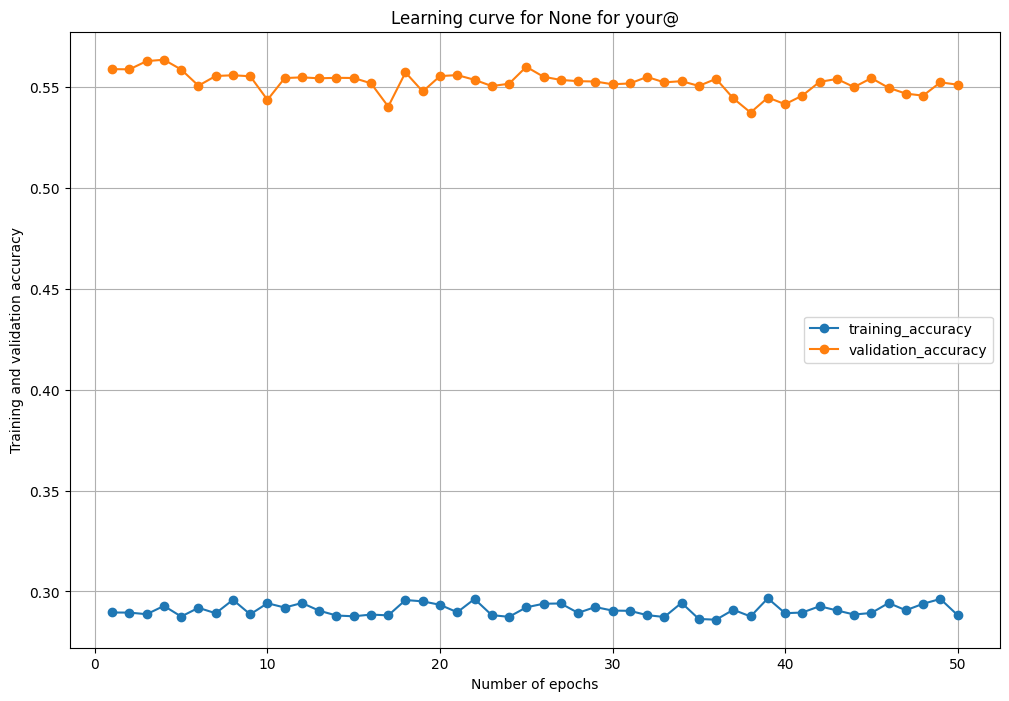

In [60]:
plot_accuracy_history(acc, title="None for your@")

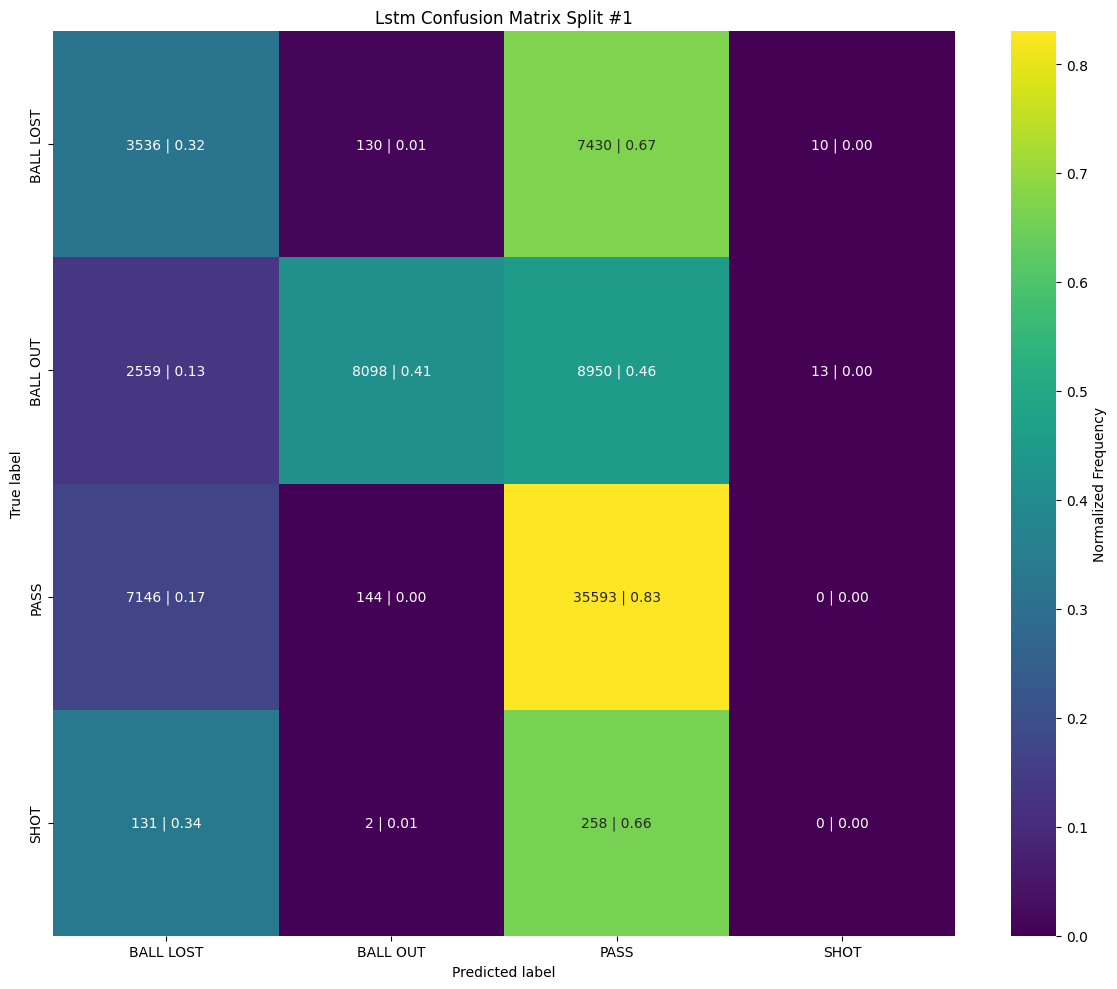

LSTM training accuracy: 99.16%
LSTM testing accuracy: 63.82%

LSTM testing precision: 69.10%
LSTM testing recall: 63.82%
LSTM testing f1: 63.05%




In [59]:
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="LSTM")

In [63]:
assert X_1_scaled.shape[1] == X_2_scaled.shape[1] == X_3_scaled.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_3).shape

gru_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 3,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.25,
    "decoder_num_layers": None
}
input_size = X_1_scaled.shape[1]
sequence_length = 50
learning_rate = 0.001
batch_size = 256
num_epochs = 30

In [64]:
class ToTensorSequential:
    def __call__(self, sample):
        X, y = sample['X'], sample['y']
        # Convert both features and labels to tensors
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }
        
transform = v2.Compose([
    ToTensorSequential(),
])


class SequenceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = {"X": self.X[idx], "y": self.y[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample["X"], sample["y"]


In [65]:
X_comb = np.concatenate([X_1_scaled, X_2_scaled])
y_comb = np.concatenate((y_1_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size).astype(float)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size).astype(float)
y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 

train_dataset = SequenceDataset(X_comb_reshaped, y_comb_reshaped, transform=transform)
validation_dataset = SequenceDataset(X_3_reshaped, y_3_reshaped, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [66]:
gru_model = get_model(GRU, params=gru_params).to(device)
gru_model

NameError: name 'inputs_size' is not defined

In [55]:
acc, y_train, y_train_pred, y_true, y_pred = train_model(gru_model, train_loader_1, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_rnn=True, accumulation_steps=8)

Epoch  1/100: Train accuracy: 30.86% | Val accuracy: 44.94% | Train loss: 1.6048 | Val loss: 1.3421 | learning rate: 0.001000 | Precision: 44.50% | Recall: 44.94% | F1: 40.94%
Epoch  2/100: Train accuracy: 31.19% | Val accuracy: 50.12% | Train loss: 1.6164 | Val loss: 1.2659 | learning rate: 0.001000 | Precision: 45.74% | Recall: 50.12% | F1: 42.84%
Epoch  3/100: Train accuracy: 31.18% | Val accuracy: 41.38% | Train loss: 1.6182 | Val loss: 1.4063 | learning rate: 0.001000 | Precision: 41.44% | Recall: 41.38% | F1: 39.41%
Epoch  4/100: Train accuracy: 30.92% | Val accuracy: 40.82% | Train loss: 1.6270 | Val loss: 1.3862 | learning rate: 0.001000 | Precision: 42.27% | Recall: 40.82% | F1: 38.60%
Epoch  5/100: Train accuracy: 30.45% | Val accuracy: 50.01% | Train loss: 1.6299 | Val loss: 1.4590 | learning rate: 0.001000 | Precision: 42.39% | Recall: 50.01% | F1: 42.43%
Epoch  6/100: Train accuracy: 30.79% | Val accuracy: 46.69% | Train loss: 1.6234 | Val loss: 1.4110 | learning rate: 0.0

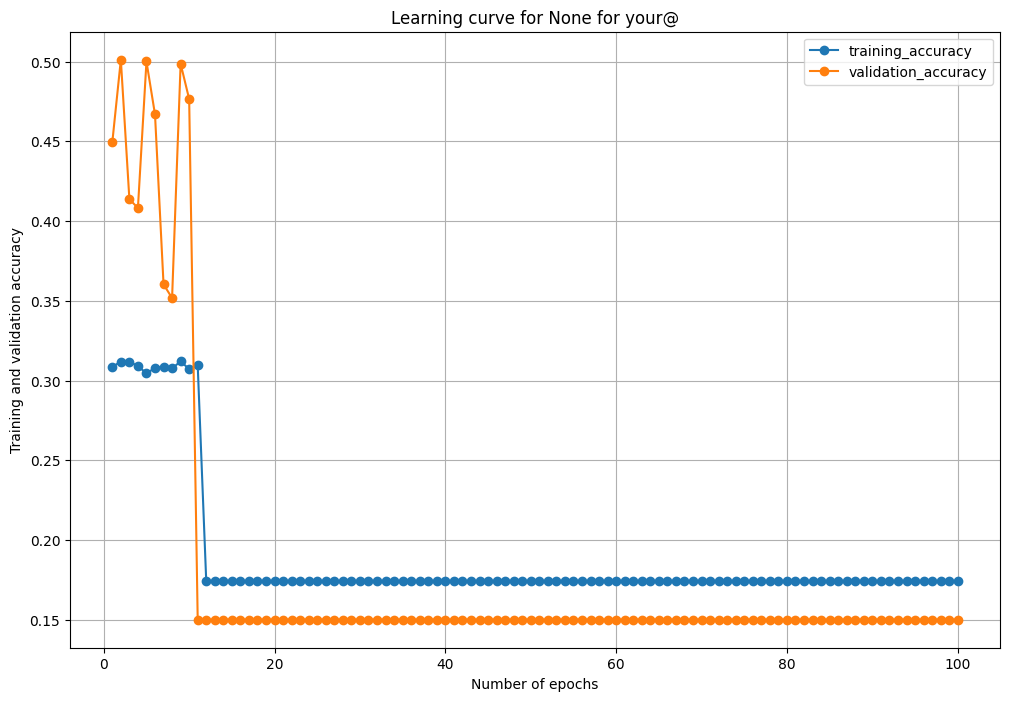

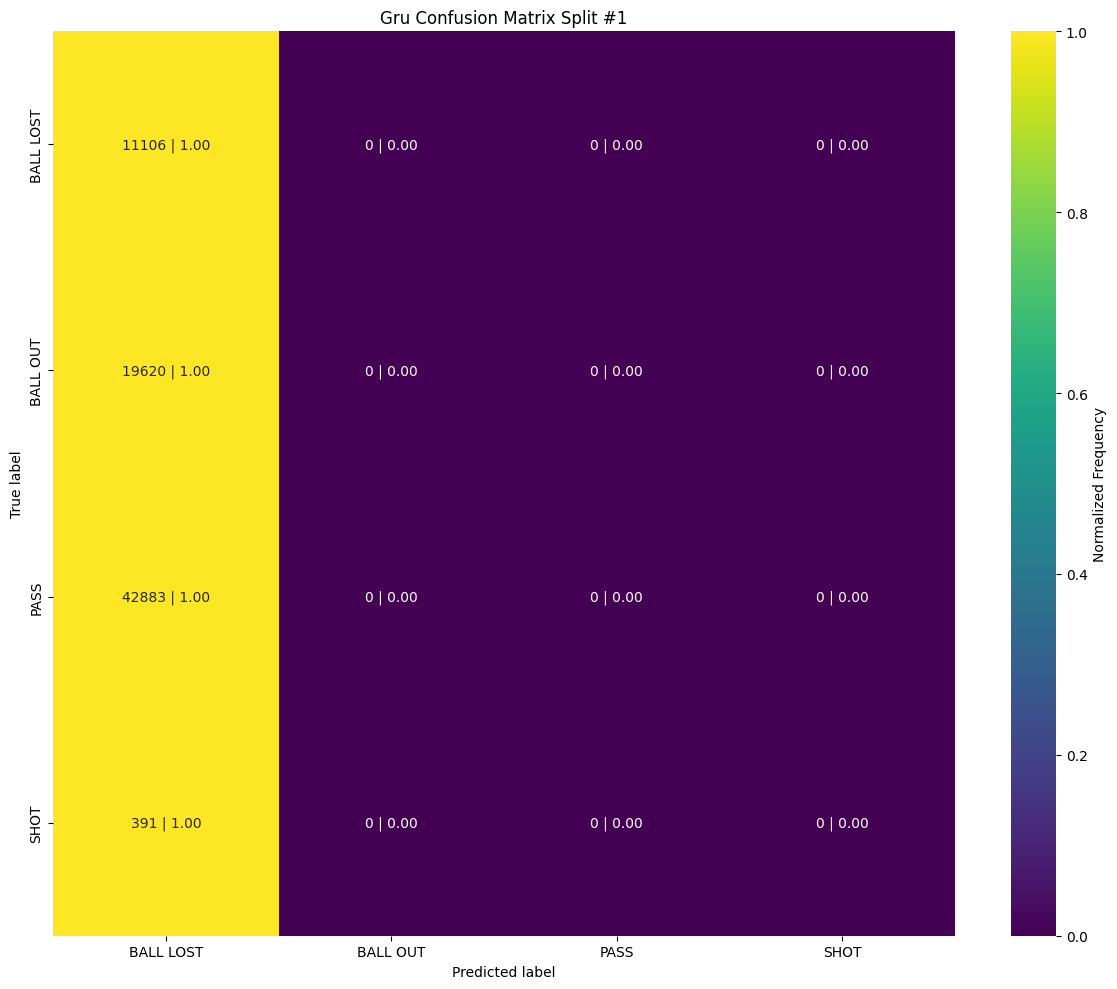

GRU training accuracy: 17.42%
GRU testing accuracy: 15.01%

GRU testing precision: 2.25%
GRU testing recall: 15.01%
GRU testing f1: 3.92%




In [56]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

In [57]:
acc, y_train, y_train_pred, y_true, y_pred = train_model(gru_model, train_loader_2, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_rnn=True, accumulation_steps=8)

Epoch  1/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1: 3.92%
Epoch  2/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1: 3.92%
Epoch  3/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1: 3.92%
Epoch  4/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1: 3.92%
Epoch  5/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1: 3.92%
Epoch  6/100: Train accuracy: 13.80% | Val accuracy: 15.01% | Train loss: nan | Val loss: nan | learning rate: 0.001000 | Precision: 2.25% | Recall: 15.01% | F1


KeyboardInterrupt



In [ ]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

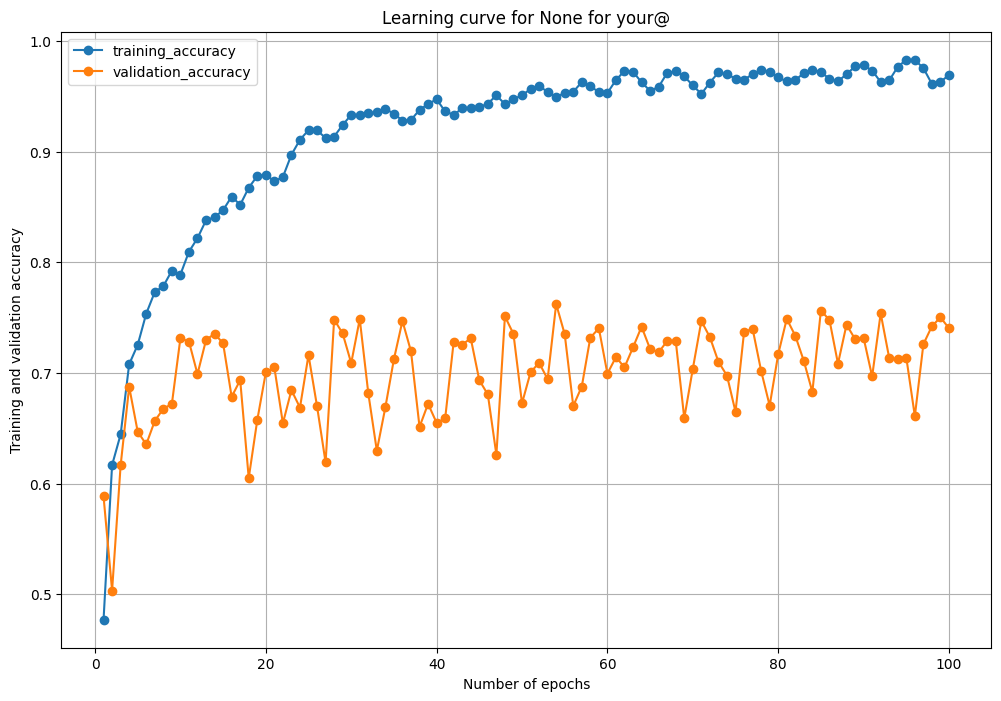

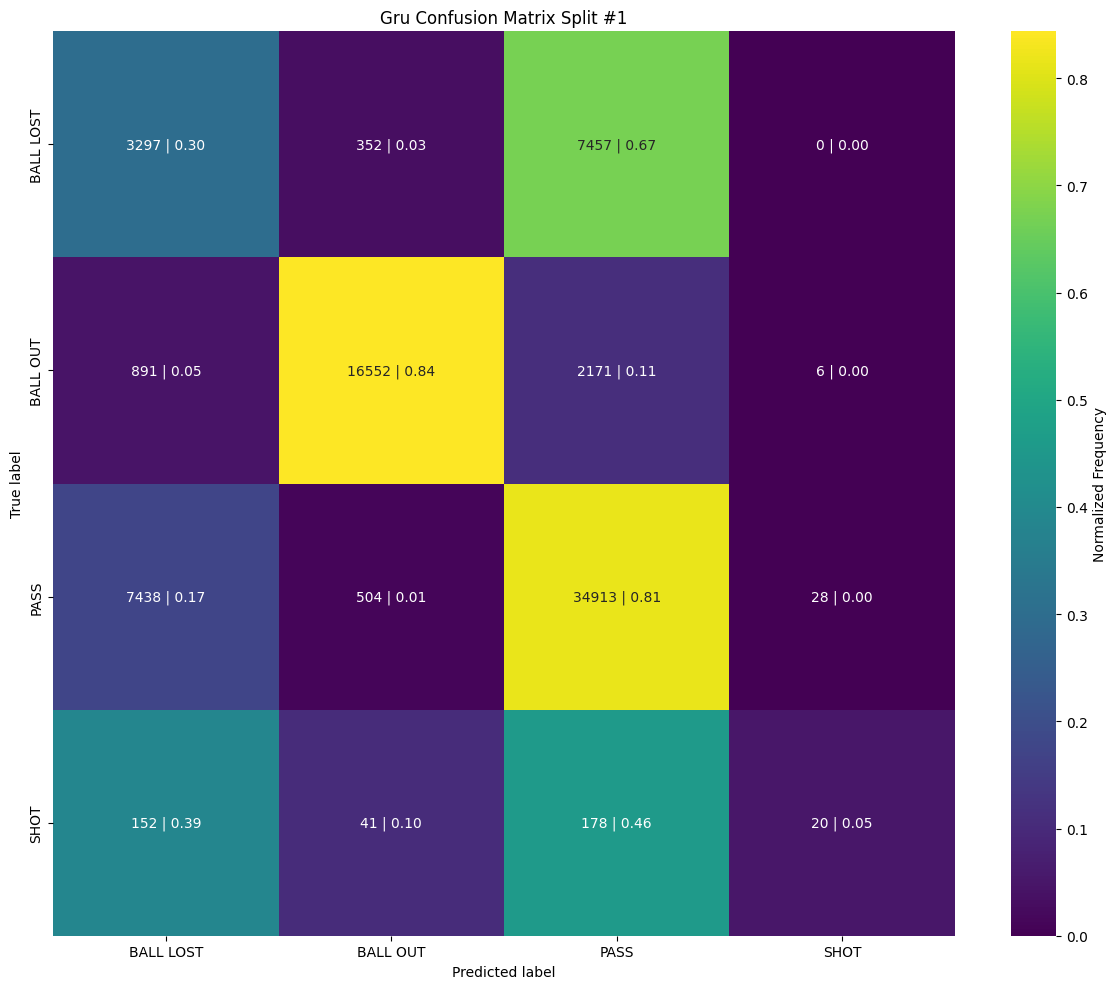

GRU training accuracy: 96.91%
GRU testing accuracy: 74.03%

GRU testing precision: 74.79%
GRU testing recall: 74.03%
GRU testing f1: 74.24%




In [60]:
plot_accuracy_history(acc, title="None for your@")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), y_test=label_encoder.inverse_transform(y_true), 
                          y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="GRU")

In [48]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, sequence_task=True):
        self.features = torch.tensor(features.values if hasattr(features, "values") else features,
                                   dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels,
                                 dtype=torch.long)
        self.sequence_task = sequence_task
        
        # Validate shapes
        assert self.features.shape[0] == self.labels.shape[0], \
            f"Number of samples mismatch: features {self.features.shape[0]}, labels {self.labels.shape[0]}"
        
        if sequence_task:
            assert self.features.shape[1] == self.labels.shape[1], \
                f"Sequence length mismatch: features {self.features.shape[1]}, labels {self.labels.shape[1]}"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [49]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = 150 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256, 512])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    if optimizer_name == "sgd":
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1, log=True)
    else:
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    num_layers = trial.suggest_int('num_layers', 1, 7)
    sequence_length = trial.suggest_categorical('sequence_length', [25, 50, 100])
    
    # Update your model's parameters using the trial's suggestions
    lstm_params = {
        "input_size": X_1_scaled.shape[1],
        "hidden_size" : hidden_size,
        "num_layers" : num_layers,
        "dropout_rate": dropout_rate,
        "num_classes" : np.unique(y_1_encoded).shape[0],
    }
    input_size = X_1_scaled.shape[1]

    # Recreate the model with the current hyperparameters
    lstm_model = get_model("lstm", lstm_params=lstm_params).to(device)

    X_comb = np.concatenate([X_1_scaled, X_2_scaled])
    y_comb = np.concatenate((y_1_encoded, y_2_encoded))
    
    X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size)
    y_comb_reshaped = y_comb.reshape(-1, sequence_length)
    
    X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size)
    y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 
    
    training_dataset = CustomDataset(X_comb_reshaped, y_comb_reshaped)
    validation_dataset = CustomDataset(X_3_reshaped, y_3_reshaped)
    
    train_loader = DataLoader(
        dataset=training_dataset, 
        batch_size=batch_size, 
        shuffle=False,
    )
    
    validation_loader = DataLoader(
        dataset=validation_dataset, 
        batch_size=batch_size, 
        shuffle=False,
    )

    acc = train_model(lstm_model, train_loader, validation_loader, num_epochs, 
                      optimizer_name=optimizer_name, 
                      criterion=nn.CrossEntropyLoss(), 
                      learning_rate=learning_rate, 
                      device=device, verbose=False, is_sequence_model=True)
    
    # Return accuracy as the objective metric (Optuna will try to maximize it)
    # print(np.mean(acc["validation_accuracy"][-20:]))
    return np.mean([np.mean(acc["training_accuracy"][-20:]), np.mean(acc["validation_accuracy"][-20:])])

# Create an Optuna study to optimize the objective
study = optuna.create_study(direction='maximize')  # direction='maximize' because we're optimizing accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")

[I 2025-03-15 16:15:44,097] A new study created in memory with name: no-name-cafe6b4b-b738-420d-aed5-caa7ea60dd99
[W 2025-03-15 16:15:44,106] Trial 0 failed with parameters: {'batch_size': 512, 'dropout_rate': 0.027664319109071966, 'hidden_size': 512, 'optimizer': 'adam', 'learning_rate': 0.00015424845250537836, 'num_layers': 5, 'sequence_length': 25} because of the following error: TypeError("get_model() got an unexpected keyword argument 'lstm_params'").
Traceback (most recent call last):
  File "C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\noill\AppData\Local\Temp\ipykernel_30360\1560194639.py", line 26, in objective
    lstm_model = get_model("lstm", lstm_params=lstm_params).to(device)
TypeError: get_model() got an unexpected keyword argument 'lstm_params'
[W 2025-03-15 16:15:44,129] Trial 0 failed with valu

TypeError: get_model() got an unexpected keyword argument 'lstm_params'

In [ ]:
25, 36, 48

In [ ]:
Best trial 25: {'batch_size': 512, 'dropout_rate': 0.4086862371340136, 'hidden_size': 256, 'optimizer': 'adam', 'learning_rate': 0.00038819623613215354, 'num_layers': 4, 'sequence_length': 25}
Best accuracy: 0.8583436768774237

In [ ]:
Trial 48 finished with value: 0.8373301638766013 and parameters: {'batch_size': 512, 'dropout_rate': 0.20523009649860546, 'hidden_size': 128, 'optimizer': 'sgd', 'learning_rate': 0.012682942484929386, 'num_layers': 6, 'sequence_length': 25}.

In [60]:
Trial 36 finished with value: 0.8292257189468093 and parameters: {'batch_size': 512, 'dropout_rate': 0.2327694778607767, 'hidden_size': 512, 'optimizer': 'sgd', 'learning_rate': 0.012815264082136263, 'num_layers': 3, 'sequence_length': 25}. Best is trial 25 with value: 0.8583436768774237.

SyntaxError: invalid syntax (4225598917.py, line 1)

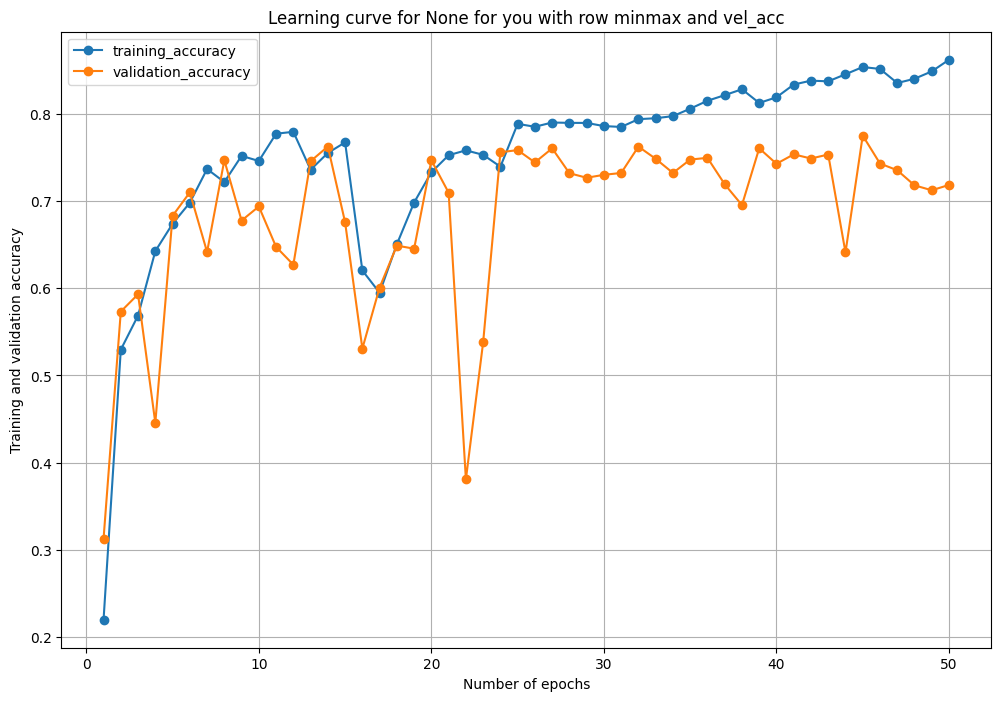

In [68]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

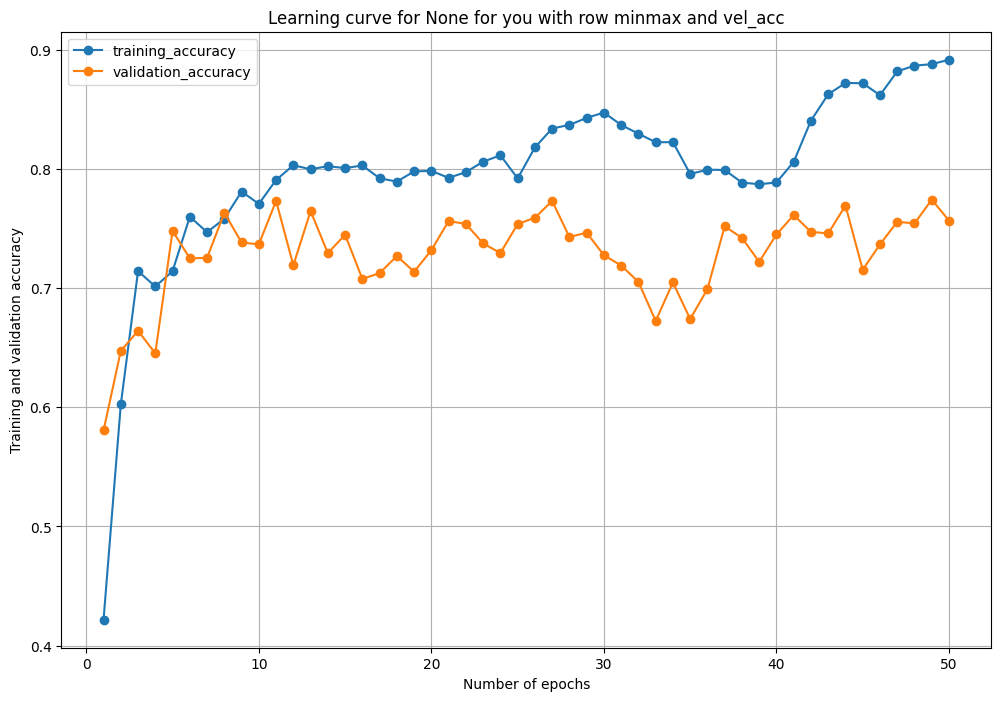

In [56]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

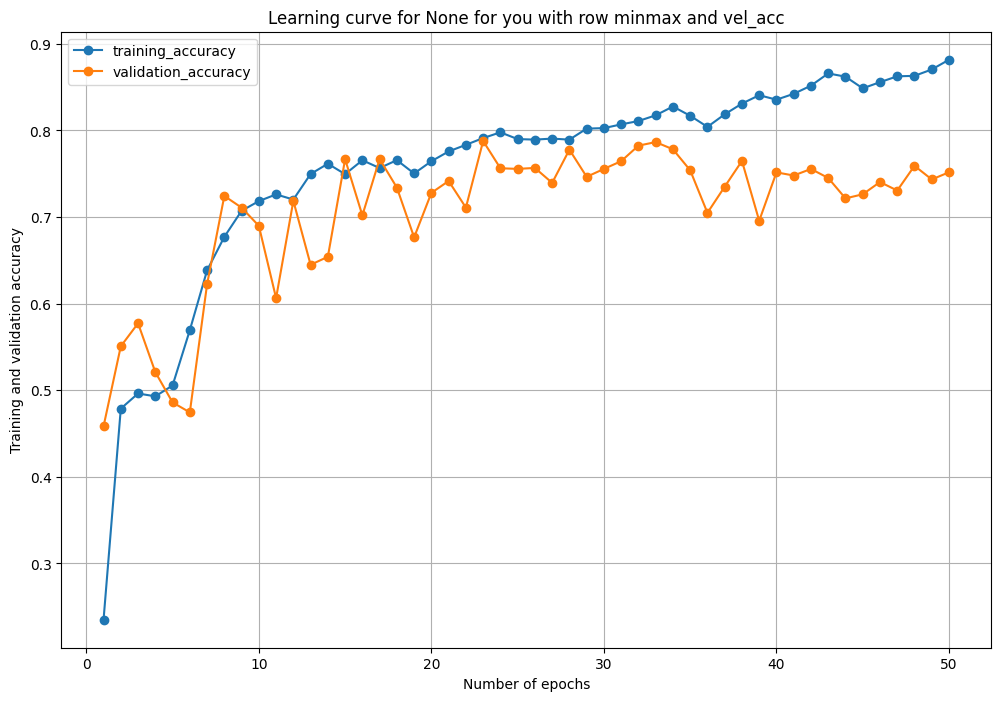

In [88]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")

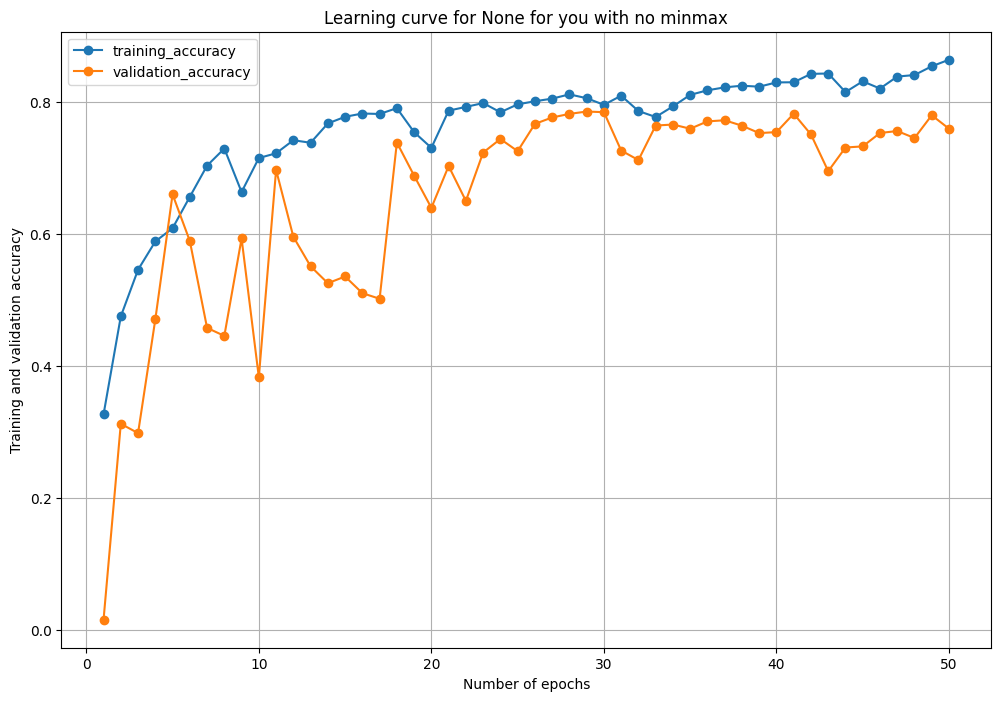

In [89]:
plot_accuracy_history(acc, title="None for you with no minmax")

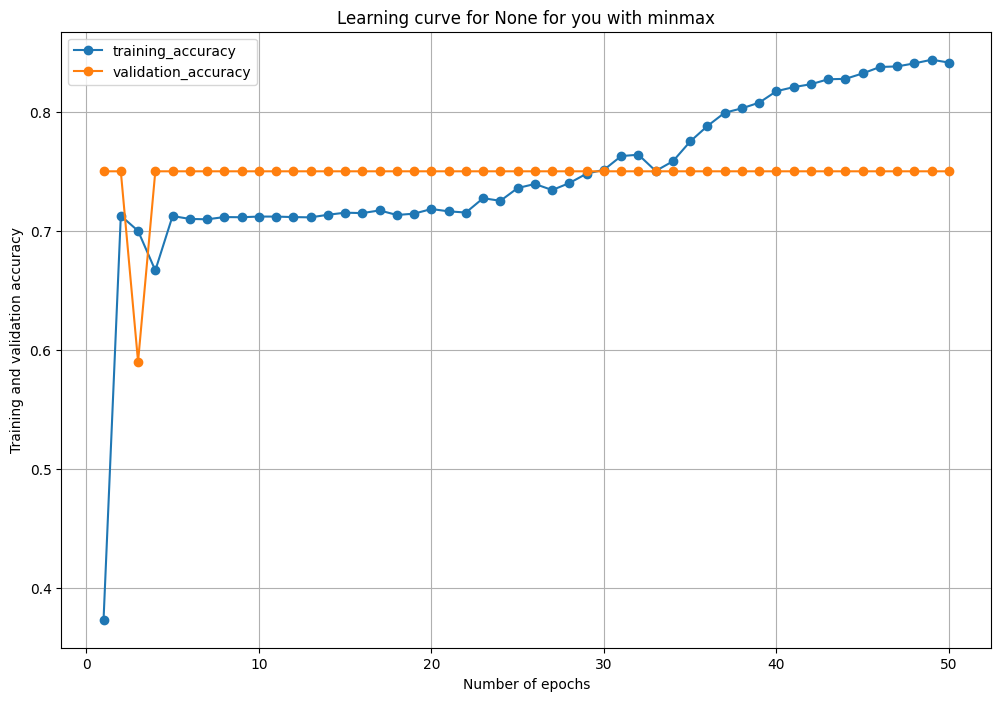

In [77]:
plot_accuracy_history(acc, title="None for you with minmax")

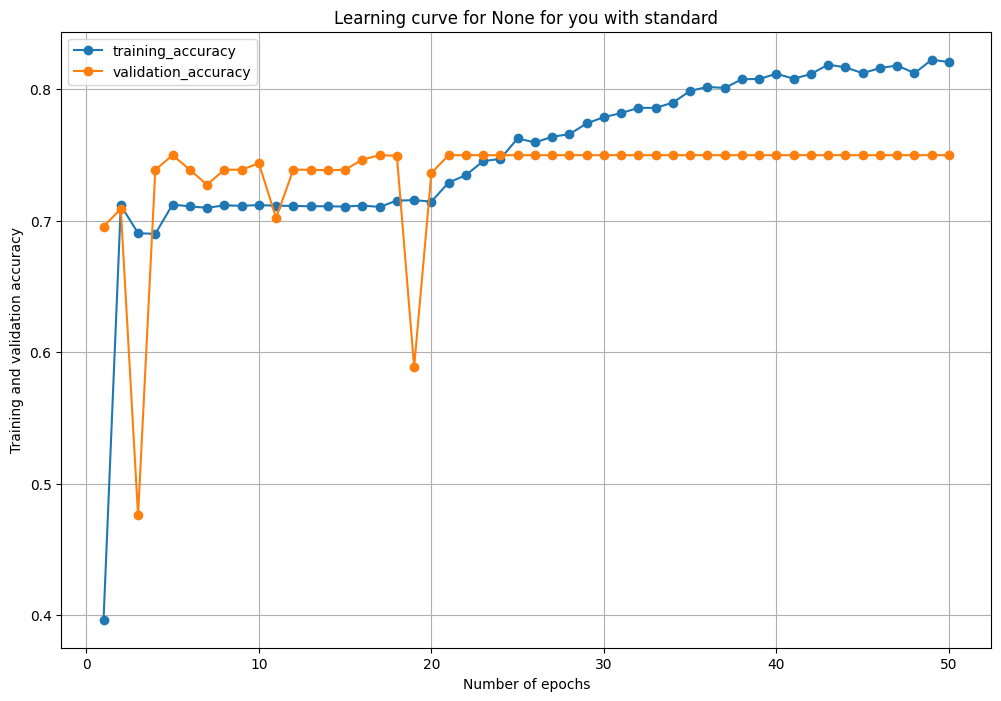

In [89]:
plot_accuracy_history(acc, title="None for you with standard")

In [ ]:
plot_accuracy(acc, title="Trial 48 with 50 SL")

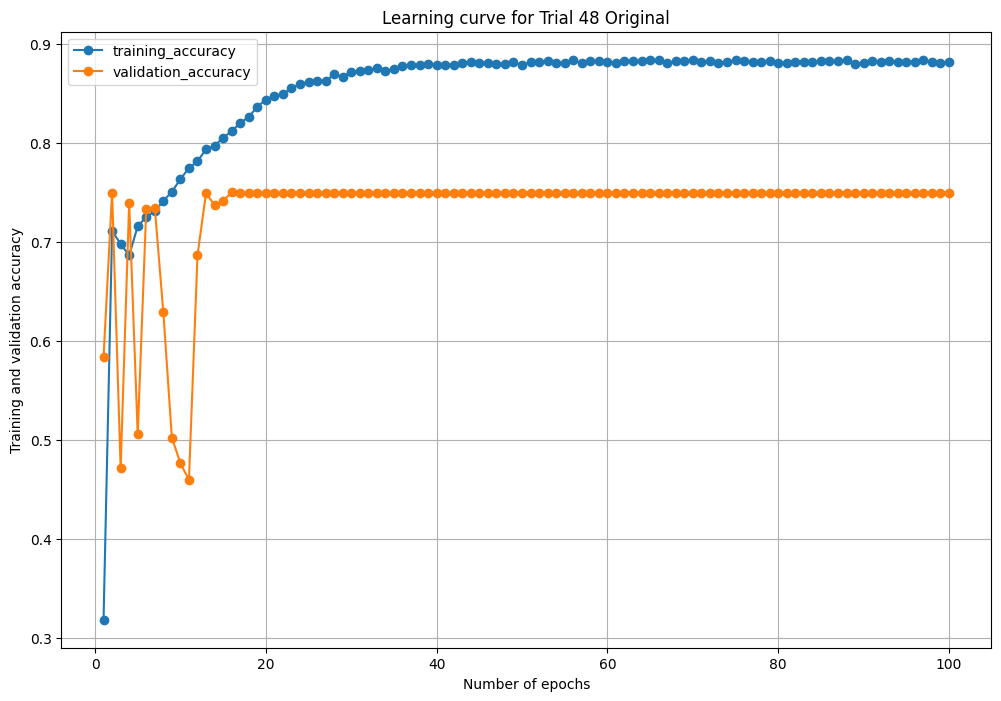

In [93]:
plot_accuracy(acc, title="Trial 48 Original")

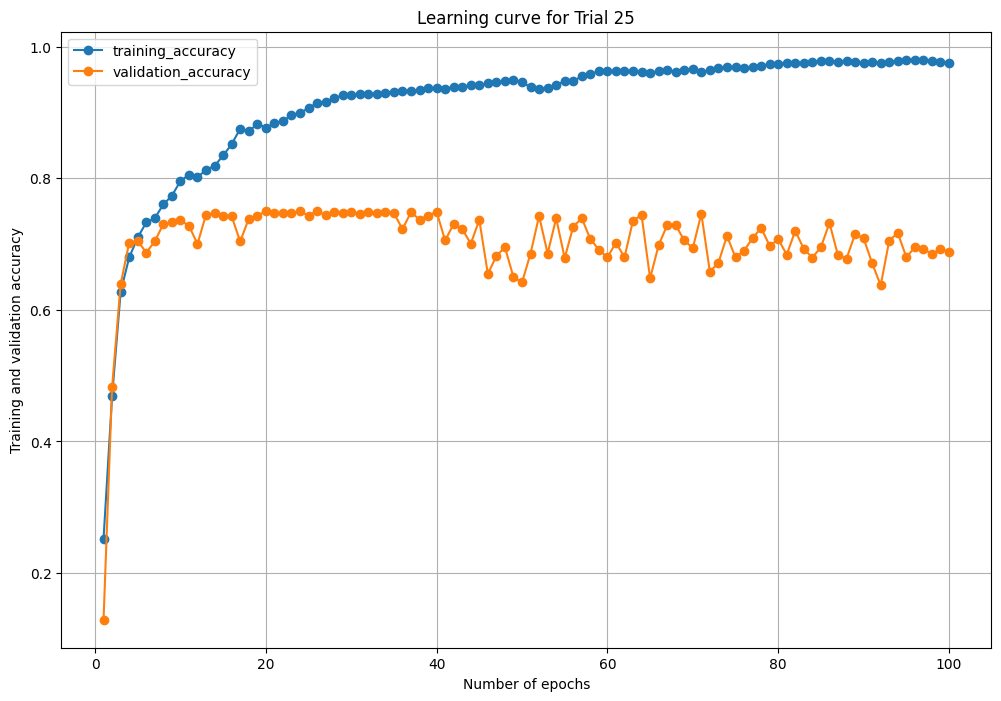

In [75]:
plot_accuracy(acc, title="Trial 25")

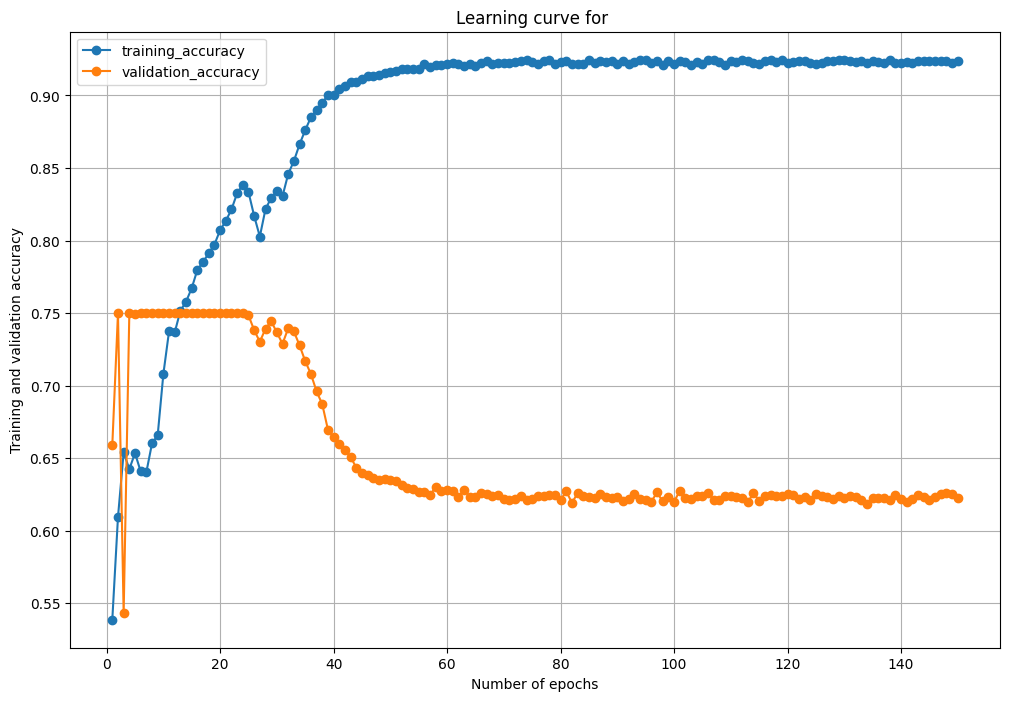

In [79]:
plot_accuracy(acc)

In [80]:
# search_space = {
#     "input_size": input_size,  # Fixed based on your data shape
#     "hidden_size": tune.choice([128, 256, 512]),  # Range of hidden sizes to explore
#     "num_layers": tune.choice([1, 2, 3, 4, 5]),  # Number of LSTM layers
#     "num_classes": num_classes,  # Fixed based on encoded classes
#     "sequence_length": sequence_length,  # Fixed
#     "learning_rate": tune.loguniform(1e-4, 1e-1),  # Log scale exploration of learning rates
#     "dropout_rate": tune.uniform(0.05, 0.5),  # Explore dropout rates from 0% to 50%
#     "batch_size": tune.choice([64, 128, 256, 512]),  # Batch sizes to try
#     "num_epochs": num_epochs  # Fixed for simplicity
# }


In [82]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.input_bn = nn.BatchNorm1d(input_size)
        
        # Define encoder and decoder
        self.encoder = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate
        )
        self.decoder = nn.LSTM(
            num_classes, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate
        )
        
        self.hidden_bn = nn.BatchNorm1d(hidden_size)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.encoder.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
                
        for name, param in self.decoder.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
       
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
                    
    def forward(self, x, target_length=None):
        # Add target_length parameter or use x.size(1) as default
        if target_length is None:
            target_length = x.size(1)  # Use input sequence length as default
            
        batch_size = x.size(0)
        
        # x shape: [batch_size, seq_len, features]
        # Transpose to: [batch_size, features, seq_len]
        x = x.transpose(1, 2)
        x = self.input_bn(x)
        # Transpose back: [batch_size, seq_len, features]
        x = x.transpose(1, 2)
        
        # Encoder
        _, (h_n, c_n) = self.encoder(x)
        
        # Decoder
        decoder_input = torch.zeros(batch_size, 1, self.num_classes).to(x.device)
        decoder_hidden = (h_n, c_n)
        outputs = []
        
        for t in range(target_length):
            out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            # out shape: [batch_size, 1, hidden_size]
            # Transpose to: [batch_size, hidden_size, 1]
            out = out.transpose(1, 2)
            out = self.hidden_bn(out)
            # Transpose back: [batch_size, 1, hidden_size]
            out = out.transpose(1, 2)
            
            prediction = self.fc(out.squeeze(1)).unsqueeze(1)
            outputs.append(prediction)
            decoder_input = prediction
            
        return torch.cat(outputs, dim=1)

In [83]:
model = Seq2SeqLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, dropout_rate=dropout_rate).to(device)
model

Seq2SeqLSTM(
  (input_bn): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): LSTM(92, 256, num_layers=3, batch_first=True)
  (decoder): LSTM(7, 256, num_layers=3, batch_first=True)
  (hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [84]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
    
    # Recreate model with suggested hyperparameters
    model = Seq2SeqLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, dropout_rate=dropout).to(device)
    
    # Choose optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0 
        val_preds = []
        val_labels = []
        
        # Training phase
        model.train()
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            train_acc += (pred == label).float().sum().item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for data, label in validation_loader:
                data, label = data.to(device), label.to(device)
                outputs = model(data)
                outputs = outputs.permute(0, 2, 1)
                loss = criterion(outputs, label)
                val_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                val_acc += (pred == label).float().sum().item()
                val_preds.extend(pred.cpu().numpy().flatten())
                val_labels.extend(label.cpu().numpy().flatten())

        val_loss /= len(validation_loader)
        
        # Calculate metrics
        val_accuracy = val_acc / (len(validation_loader.dataset) * sequence_length)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        scheduler.step(val_loss)
        
    # Return the metric to optimize (F1 score)
    return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Print best parameters and score
print("Best trial:")
trial = study.best_trial
print(f"  Value (Accuracy): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-01-24 18:20:03,550] A new study created in memory with name: no-name-edbb7c3b-b57c-466b-b545-971bcdffa400
C:\Users\noill\AppData\Local\Temp\ipykernel_16012\3812196583.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
C:\Users\noill\AppData\Local\Temp\ipykernel_16012\3812196583.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
[I 2025-01-24 18:26:16,064] Trial 0 finished with value: 0.4559353348729792 and parameters: {'learning_rate': 1.3413133813964387e-05, 'optimizer': 'Adam', 'hidden_size': 492, 'num_layers': 4, 'dropout': 0.11200968955661061}. Best is 

In [322]:
test_acc = 0
test_loss = 0
test_dataset_len = len(test_loader.dataset)
test_preds = []
test_labels = []

model.eval()

with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        outputs = model(data)
        outputs = outputs.permute(0, 2, 1)

        test_loss += criterion(outputs, label).item()

        _, pred = torch.max(outputs, 1)
        test_acc += (pred == label).float().sum().item()

        # Collect predictions and ground truth for metrics
        test_preds.extend(pred.cpu().numpy().flatten())
        test_labels.extend(label.cpu().numpy().flatten())

    test_loss /= len(test_loader)
    test_accuracy = test_acc / (test_dataset_len * sequence_length)
    accu["testing_accuracy"].append(test_accuracy)

    test_precision = precision_score(test_labels, test_preds, average="weighted", zero_division=0)
    test_recall = recall_score(test_labels, test_preds, average="weighted", zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, average="weighted", zero_division=0)

print(f"testing accuracy: {test_accuracy * 100:.2f}% | "
      f"test loss: {test_loss:.4f} | "
      f"test precision: {test_precision * 100:0.2f}% | test recall: {test_recall * 100:0.2f}% | test f1: {test_f1 * 100:0.2f}%")

testing accuracy: 66.26% | test loss: 3.0546 | test precision: 63.15% | test recall: 66.26% | test f1: 64.60%


In [323]:
def plot_accuracy(accuracy, title=""):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

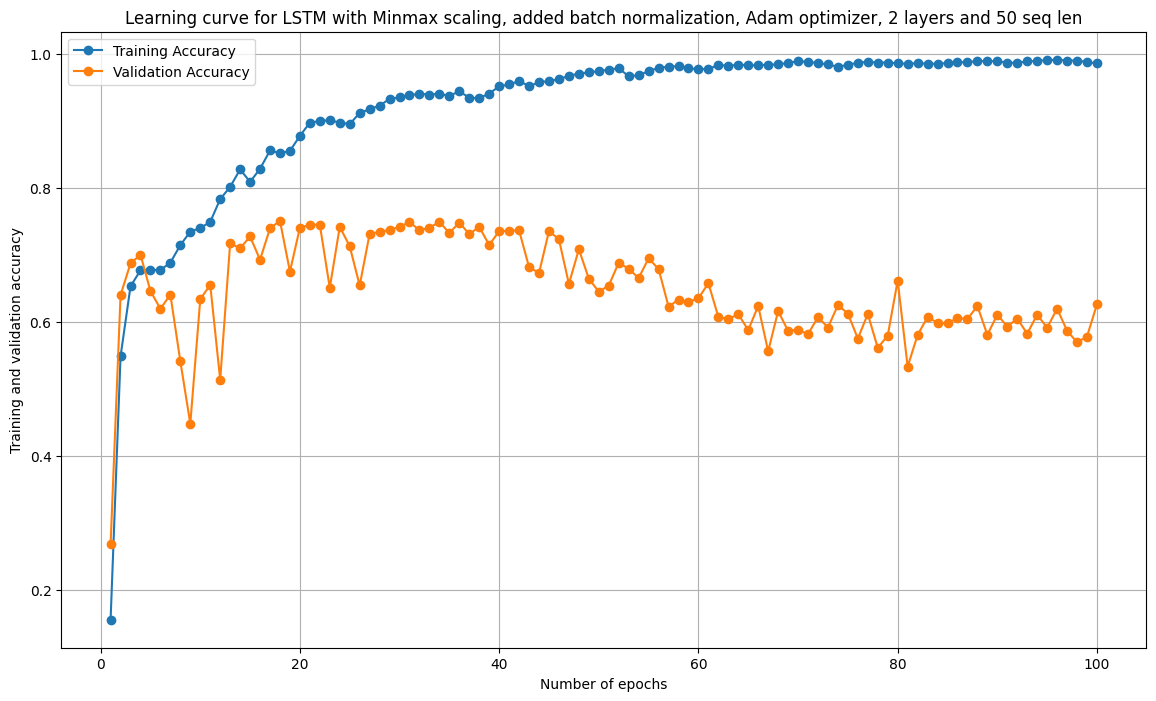

In [110]:
plot_accuracy(accu, title="LSTM with Minmax scaling, added batch normalization, Adam optimizer, 2 layers and 50 seq len")

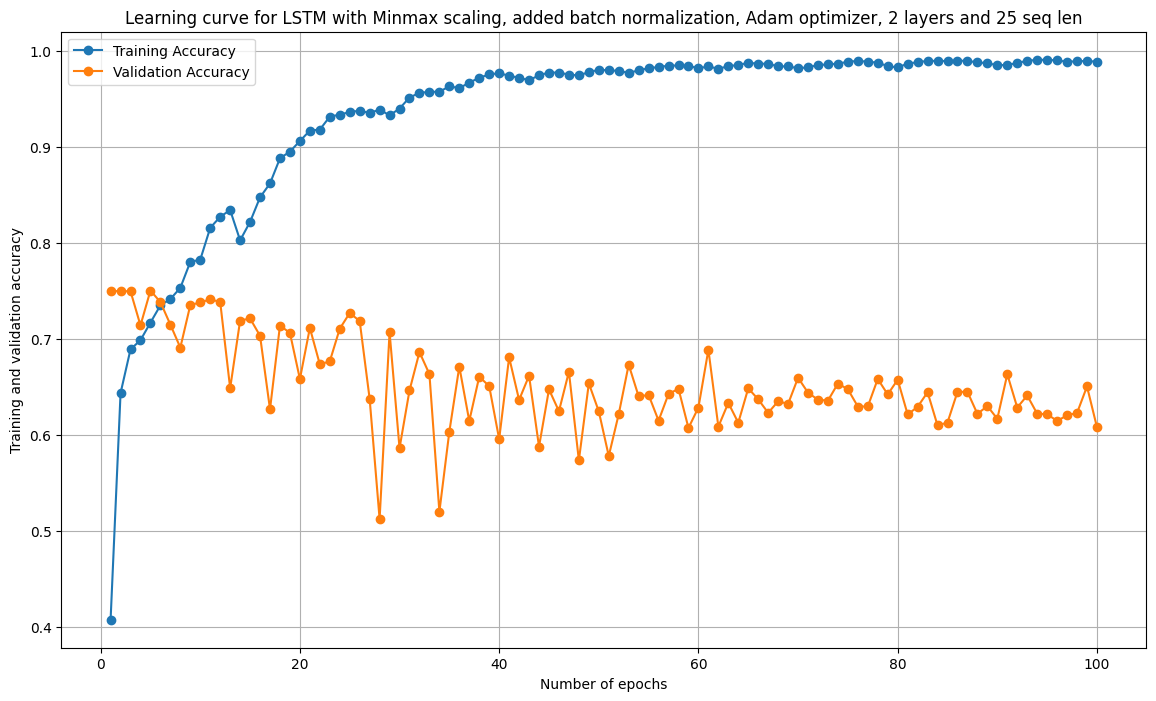

In [94]:
plot_accuracy(accu, title="LSTM with Minmax scaling, added batch normalization, Adam optimizer, 2 layers and 25 seq len")

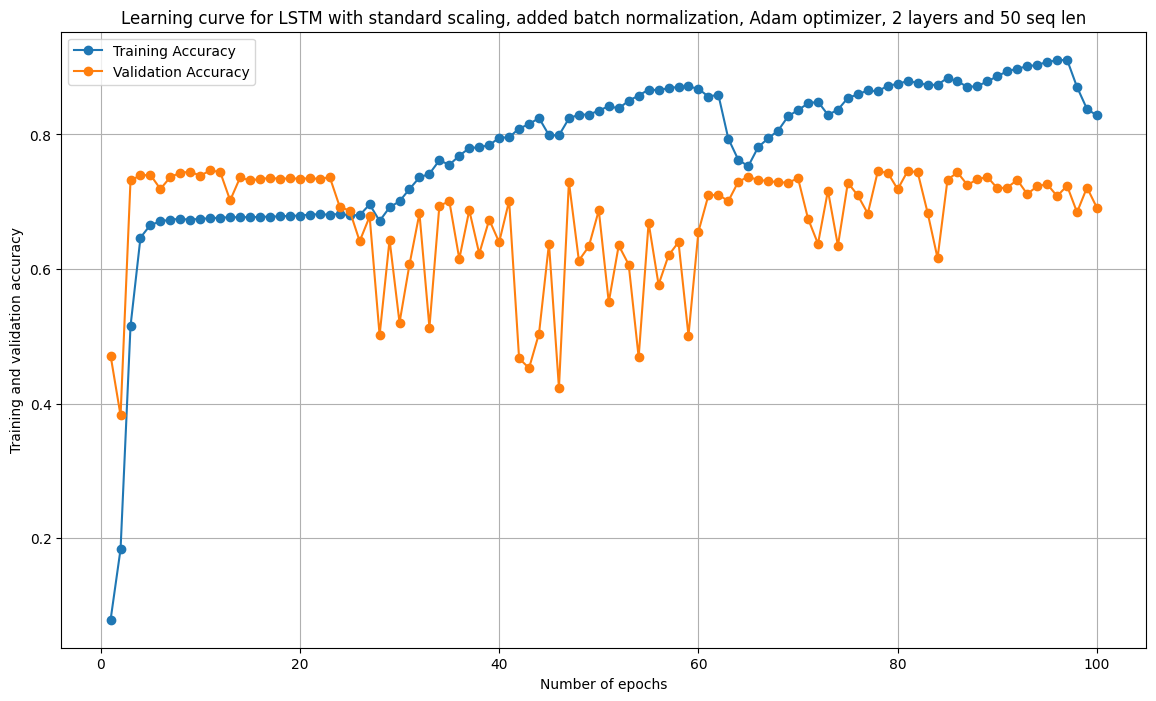

In [143]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, Adam optimizer, 2 layers and 50 seq len")

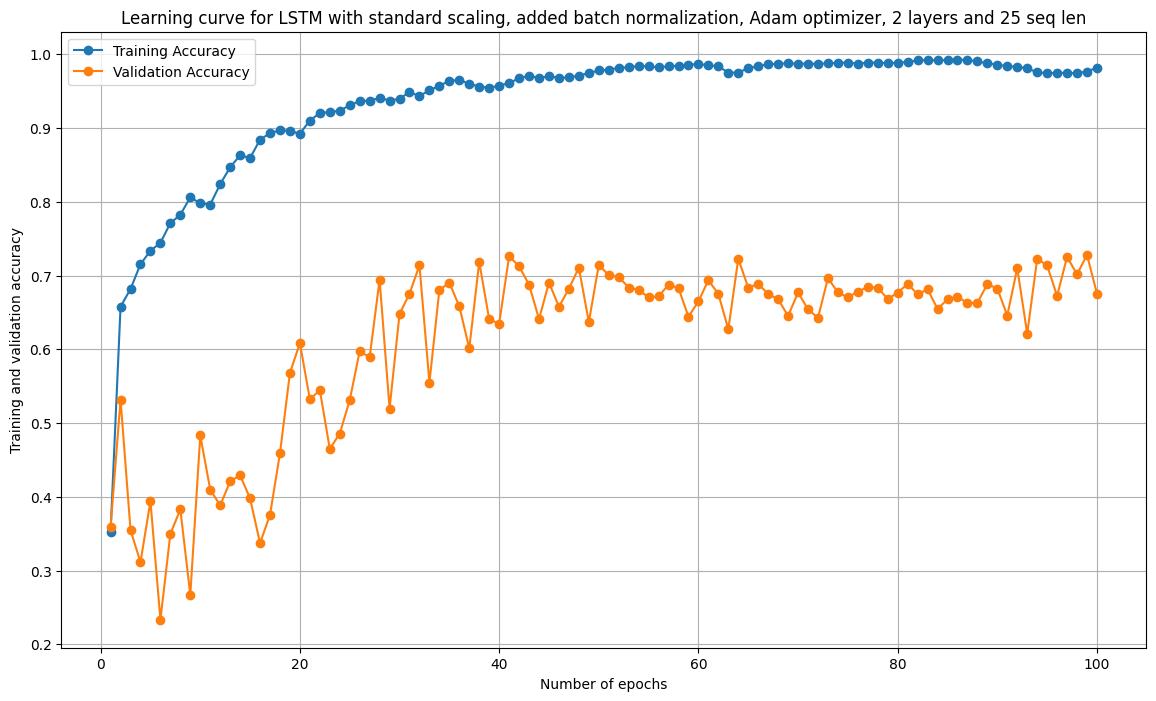

In [237]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, Adam optimizer, 2 layers and 25 seq len") # 0.0

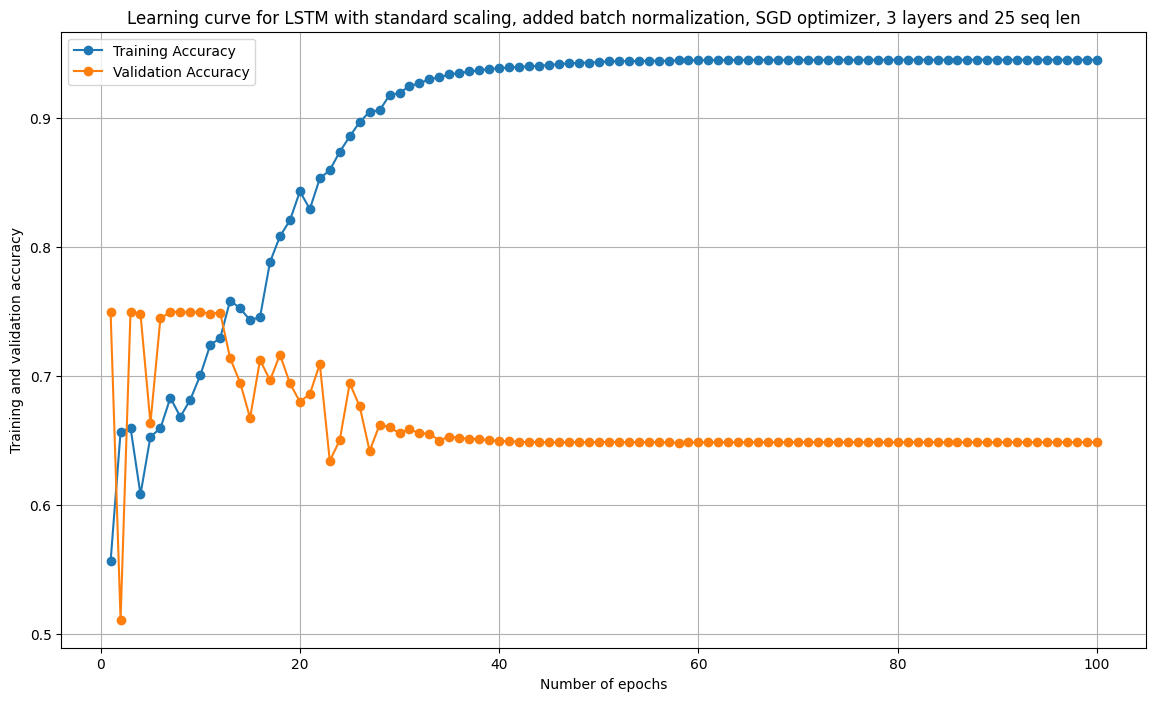

In [324]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, SGD optimizer, 3 layers and 25 seq len") # 0.0

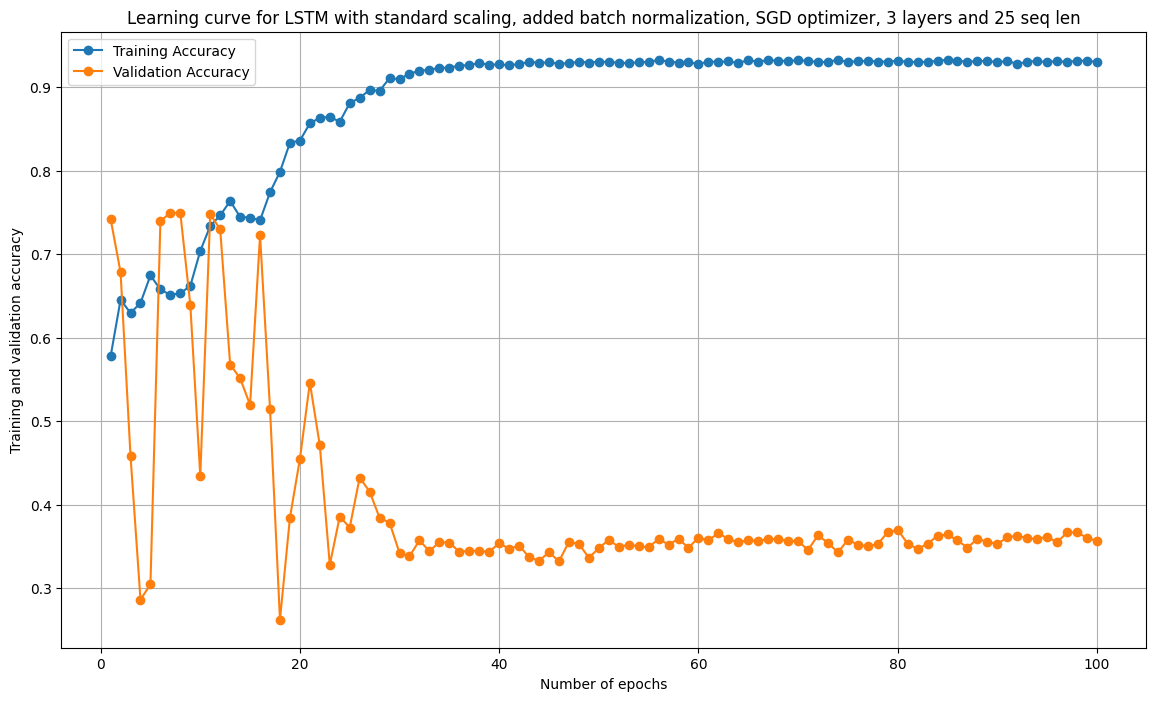

In [287]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, SGD optimizer, 3 layers and 25 seq len") # 0.1

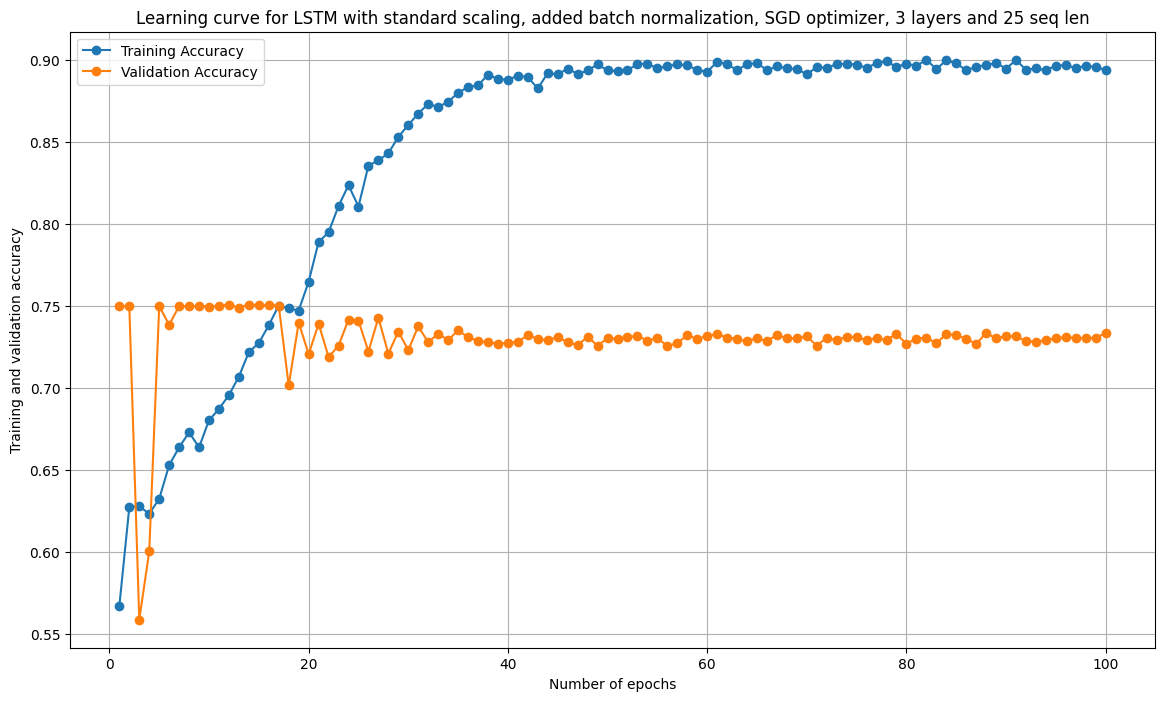

In [261]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, SGD optimizer, 3 layers and 25 seq len") # 0.2